In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
import gensim
import os
import spacy

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from num2words import num2words
from nltk.stem import WordNetLemmatizer 

%matplotlib inline
np.random.seed(400)
nlp = spacy.load("en_core_web_sm")

## Helper Functions 

### Lower Casing The Data

- Convert String to Lower Case

#### Example:

"Hello World" -> "hello world"

In [2]:
# Lower Casing the Data
def convert_lower_case(data):
    return np.char.lower(data)

### Removing Stop Words

- Frequently used in English language, but do not carry the thematic component.

#### Example:

"ever", "far", "about" etc.

In [3]:
# Removing Stop Words
def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

### Removing Punctuations


#### Example:

"Hello World!??" -> "Hello World"

In [4]:
# Remove Punctuations
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

### Removing Apostrophe

#### Example:

"I'm John" -> "Im John"

In [5]:
# Remove Apostrophe
def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

### Removing Specific Words as per Requirements

- For this specific case, words like "Terms" "Use" "Service" "Facebook" etc. appear often and should be removed.
- We do this since we don't want to add any bias to the model


In [6]:
def remove_words(data,filter_words):
    for i in range(len(filter_words)):
        data = np.char.replace(data,filter_words[i],"")
        
    return data

### Stemming

- Stemming is basically removing the suffix from a word and reduce it to its root word. 

#### Example:

“Flying” is a word and its suffix is “ing”, if we remove “ing” from “Flying” then we will get base word or root word which is “Fly”.

In [7]:
# Stemming
def stemming(data):
    stemmer= PorterStemmer()
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

### Lemmatization

- Lemmatization takes into consideration the morphological analysis of the words. Stemming does not retain meaning but Lemmatization does

#### Example:

A Stemmer will convert "Studies" to "Studi" but a Lemmatizer will convert "Studies" to "Study"

In [8]:
def lemmatize(data):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmatizer.lemmatize(w)
        
    return new_text

### Convert Numbers to Words


#### Example:

200 -> "Two Hundred"

In [9]:
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

### Specific POS Tagging

- We POS Tag each word but take only the **Nouns, Proper Nouns and the Verbs** since they have a higher weight on describing a document.


In [10]:
def spacy_preprocess(text):
    text = nlp(text)
    candidate_pos = ['NOUN', 'PROPN', 'VERB']
    jd = []
    for token in text:
        if token.pos_ in candidate_pos and token.is_stop is False:
            jd.append(str(token))

    return jd

In [11]:
def preprocess(data,filter_words):
    print("Lower Casing the Data..")
    data = convert_lower_case(data)
    print("Removing all punctuations...")
    data = remove_punctuation(data) #remove comma seperately
    print("Removing apostrophe...")
    data = remove_apostrophe(data)
    print("Removing Filter Words...")
    data = remove_words(data,filter_words)
    print("Removing Stop Words...")
    data = remove_stop_words(data)
    print("Converting Numerics to Words...")
    data = convert_numbers(data)
    print("Removing Punctuations Again...")
    data = remove_punctuation(data)
    print("Removing Stop Words Again...")
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    print("Lemmatization...")
    data = lemmatize(data)
#     print("Stemming...")
#     data = stemming(data)
    print("Preprocessing...\n\n")
    data = spacy_preprocess(data)
    return data


# Reading All the Terms and Condition Files

In [12]:
filter_words = ["facebook","whatsapp","instagram","terms","service","use"]
files = ['fb_terms.txt' ,'wa_terms.txt','insta_terms.txt']
docs = []
for file in files:
    with open(file,'rb') as terms:
        docs.append(terms.read().decode('utf-8'))

# Preprocessing Documents

### This Step Involves

- Preprocessing the Documents using various techniques like Stemming and Lemmatization
- Creating a Dictionary which is essentially a mapping of a word to it's integer ID

In [13]:
doc = docs
processed = [preprocess(docu,filter_words) for docu in doc]
dictionary = gensim.corpora.Dictionary(processed)

Lower Casing the Data..
Removing all punctuations...
Removing apostrophe...
Removing Filter Words...
Removing Stop Words...
Converting Numerics to Words...
Removing Punctuations Again...
Removing Stop Words Again...
Lemmatization...
Preprocessing...


Lower Casing the Data..
Removing all punctuations...
Removing apostrophe...
Removing Filter Words...
Removing Stop Words...
Converting Numerics to Words...
Removing Punctuations Again...
Removing Stop Words Again...
Lemmatization...
Preprocessing...


Lower Casing the Data..
Removing all punctuations...
Removing apostrophe...
Removing Filter Words...
Removing Stop Words...
Converting Numerics to Words...
Removing Punctuations Again...
Removing Stop Words Again...
Lemmatization...
Preprocessing...




# Creating the Bag of Words Corpus

### This step creates 
- A BOW Corpus which essentially maps the occurences of words in each document

In [14]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

# Example BOW for Document 0

In [15]:
document_num = 0
bow_doc_x = bow_corpus[document_num]
for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 0 ("ability") appears 3 time.
Word 1 ("access") appears 11 time.
Word 2 ("accordance") appears 1 time.
Word 3 ("account") appears 19 time.
Word 4 ("acquisition") appears 1 time.
Word 5 ("action") appears 8 time.
Word 6 ("activity") appears 5 time.
Word 7 ("ad") appears 28 time.
Word 8 ("add") appears 1 time.
Word 9 ("adding") appears 1 time.
Word 10 ("address") appears 2 time.
Word 11 ("administer") appears 1 time.
Word 12 ("administrative") appears 1 time.
Word 13 ("advance") appears 3 time.
Word 14 ("advertise") appears 1 time.
Word 15 ("advertiser") appears 9 time.
Word 16 ("advertising") appears 4 time.
Word 17 ("advised") appears 1 time.
Word 18 ("affiliate") appears 1 time.
Word 19 ("age") appears 3 time.
Word 20 ("agency") appears 1 time.
Word 21 ("agree") appears 7 time.
Word 22 ("agreement") appears 4 time.
Word 23 ("allow") appears 1 time.
Word 24 ("allowed") appears 1 time.
Word 25 ("amendment") appears 1 time.
Word 26 ("analyzing") appears 1 time.
Word 27 ("app") appea

# We use Latent Dirichlet Allocation (LDA) as our preffered Topic Modelling Technique

### LDA uses Dirichlets and Multinomial Probabilities to Generate Topics


<img src="LDA2.PNG" width="600px">


<br>
<br>


### Consider LDA as a Machine
- We Fine Tune the machine such that it becomes capable of regenerating the article
- We try all possibilities and get the machine which is most likely to regenerate the articles
- This returns the topics for that article
- In a similar way, we find such machines for all articles

<b

<img src="LDA1.PNG" width="600px">

In [16]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dictionary,                                    
                                   passes = 2,
                                   workers = 2)

# Generating Topics using LDA

In [17]:
for idx, topic in lda_model.print_topics(-1):
    topic_words = topic.split('+')
    fin_words = []
    for i in range(len(topic_words)):
        fin_words.append(topic_words[i].strip().split('*')[1].replace("\"",""))

    print(fin_words)
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

['content', 'product', 'account', 'information', 'policy', 'ad', 'people', 'data', 'provide', 'community']
Topic: 0 
Words: 0.027*"content" + 0.026*"product" + 0.016*"account" + 0.015*"information" + 0.014*"policy" + 0.013*"ad" + 0.013*"people" + 0.013*"data" + 0.012*"provide" + 0.012*"community"


['content', 'product', 'account', 'dispute', 'information', 'data', 'share', 'provide', 'policy', 'including']
Topic: 1 
Words: 0.013*"content" + 0.011*"product" + 0.007*"account" + 0.007*"dispute" + 0.007*"information" + 0.006*"data" + 0.006*"share" + 0.006*"provide" + 0.006*"policy" + 0.005*"including"


['dispute', 'arbitration', 'law', 'product', 'information', 'state', 'including', 'provide', 'content', 'united']
Topic: 2 
Words: 0.007*"dispute" + 0.007*"arbitration" + 0.006*"law" + 0.006*"product" + 0.006*"information" + 0.005*"state" + 0.005*"including" + 0.005*"provide" + 0.005*"content" + 0.005*"united"


['dispute', 'arbitration', 'state', 'including', 'r', 'law', 'united', 'inform

# Visualization of the Topics Generated

Text(0.5, 1.0, 'Topic 1')

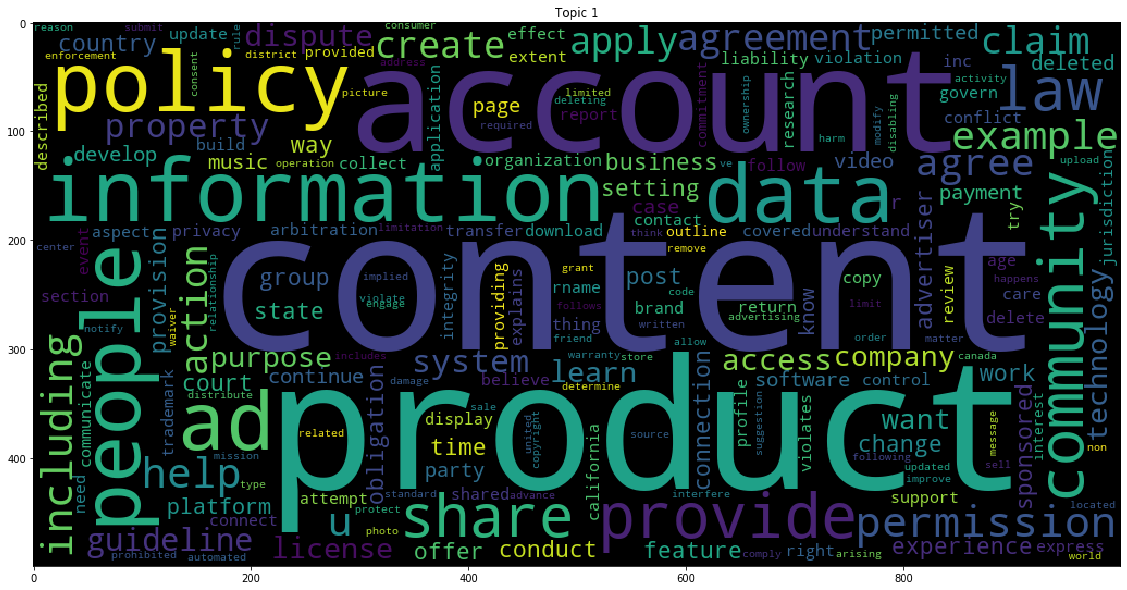

In [18]:
topic = lda_model.show_topic(0,200)
wctopic = {}
for i in range(len(topic)):
    wctopic[topic[i][0]] = topic[i][1]
    
    
from wordcloud import WordCloud
plt.figure(figsize=(20,10))
plt.imshow(WordCloud(width=1000, height=500).fit_words(wctopic))
plt.title("Topic 1")

Text(0.5, 1.0, 'Topic 2')

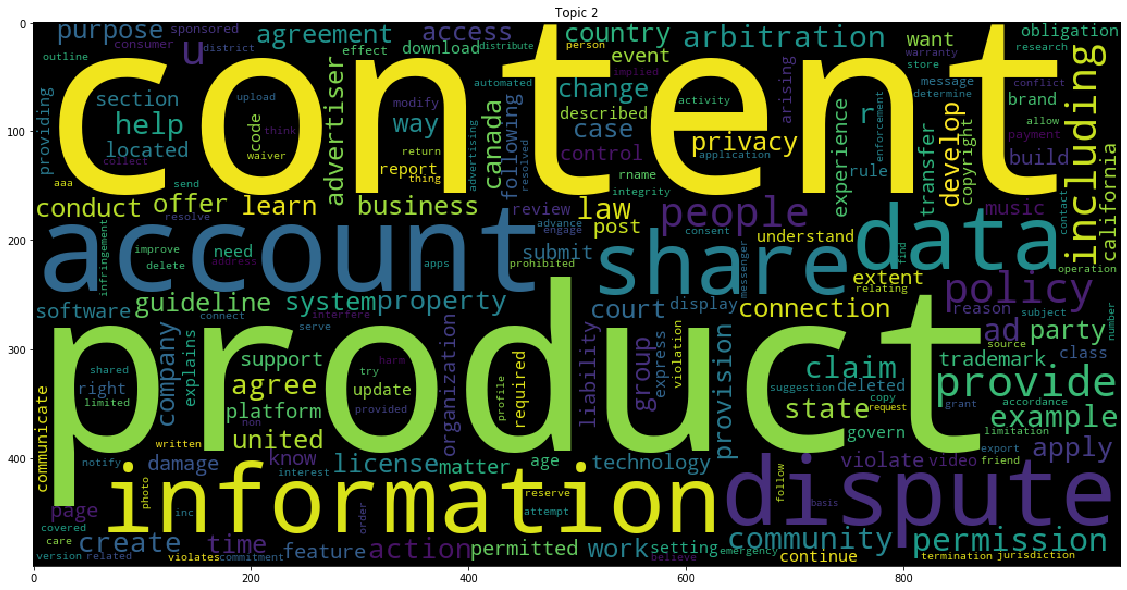

In [19]:
topic = lda_model.show_topic(1,200)
wctopic = {}
for i in range(len(topic)):
    wctopic[topic[i][0]] = topic[i][1]
    
    
from wordcloud import WordCloud
plt.figure(figsize=(20,10))
plt.imshow(WordCloud(width=1000, height=500).fit_words(wctopic))
plt.title("Topic 2")

Text(0.5, 1.0, 'Topic 3')

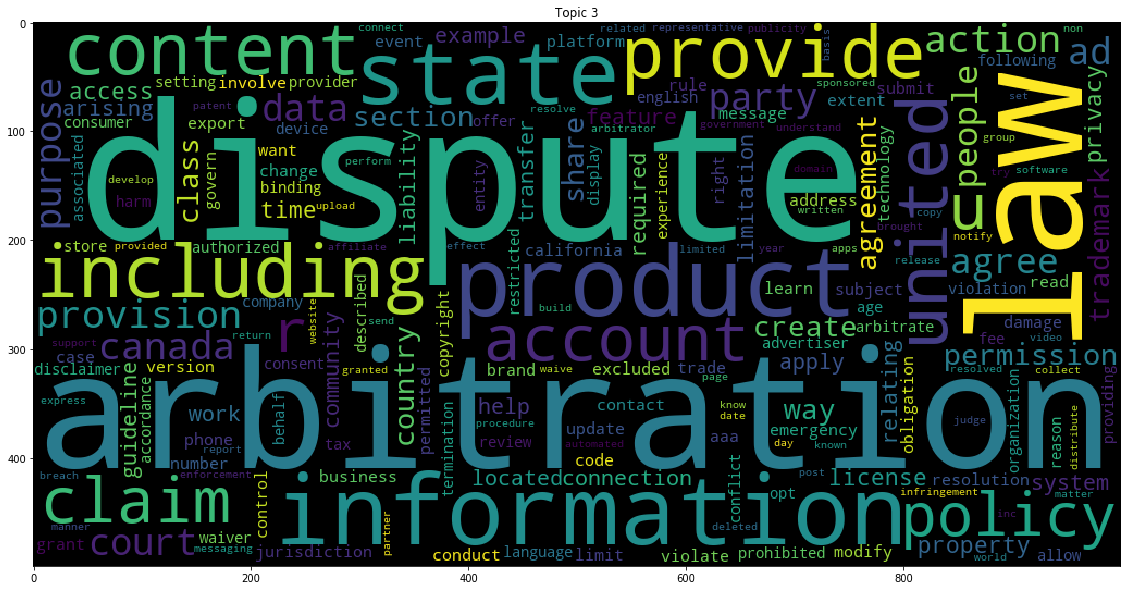

In [20]:
topic = lda_model.show_topic(2,200)
wctopic = {}
for i in range(len(topic)):
    wctopic[topic[i][0]] = topic[i][1]
    
    
from wordcloud import WordCloud
plt.figure(figsize=(20,10))
plt.imshow(WordCloud(width=1000, height=500).fit_words(wctopic))
plt.title("Topic 3")